In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

Table of Contents
    1. Data Preprocessing
    2. Linear Regression
        1. Standard Linear Regression
        2. ElasticNet
        3. Lasso
        4. Comparison of Methods
    3. Classification
        1. Setup
        2. Classifier Evaluation (With 3 bins and 4 bins)
        3. Learning Curves
        4. Feature Importance Rankings

In [2]:
sns.set_style()
path = 'Pickles/output_df.pkl'
df = pd.read_pickle(path)
df.columns

Index(['artists', 'date', 'TM_id', 'event_title', 'presale_date_end',
       'presale_date_start', 'promoter', 'TM_sale_date_start',
       'span multiple days', 'venue', 'TM_venue _lat', 'venue_city',
       'TM_venue_long', 'venue_state', 'TM_max', 'TM_min', 'genre', 'subGenre',
       'event_type', 'SG_artists_score', 'SG_average_price',
       'SG_listing_count', 'SG_max_price', 'SG_min_price', 'SG_venue_score',
       'SH_max_price', 'SH_min_price', 'SH_total_postings', 'SH_total_tickets',
       'spotify_followers', 'spotify_popularity', 'spotify_avg_followers',
       'spotify_avg_popularity', 'spotify_null_count', 'days_until_show',
       'day_of_week', 'presale_length', 'days_on_sale', 'artist_count',
       'avg_resale_min', 'avg_resale_max', 'min_source', 'max_source',
       'min_markup%', 'max_markup%', 'avg_ticket_listings'],
      dtype='object')

## 1. Data Preprocessing
Drop extra columns and one hot encode categorical features (Dropping the first category to avoid collinearity)

In [3]:
##Drop excess columns 
df = df[['min_markup%','promoter','venue_state','TM_min','genre','subGenre','spotify_avg_followers',
         'spotify_avg_popularity','spotify_null_count','days_until_show','day_of_week',
         'presale_length','days_on_sale','artist_count','min_source','avg_ticket_listings']]

In [4]:
#One Hot Encode categorical variables
df_onehot = pd.get_dummies(columns=['promoter','venue_state','genre','min_source','subGenre','day_of_week'],
                           data=df,drop_first=True)

#Seperate into X and Y matrices
X = df_onehot.iloc[:,1:]
Y = df_onehot['min_markup%']

#Split into training and test set
X,X_test,Y,Y_test =  train_test_split(X,Y,test_size=.2,random_state=1)

#Scale numerical data
cont_features = ['TM_min','spotify_avg_followers',
'spotify_avg_popularity','days_until_show','presale_length','days_on_sale',
 'artist_count','avg_ticket_listings']
Xscaler = StandardScaler()
X[cont_features] = Xscaler.fit_transform(X[cont_features])

#Set all negative markups to .01
Y_log = Y.copy()
Y_log[Y_log <= 0] = .01
Y_log = np.log(Y_log)

## 2. Linear Regression
    1. Standard Linear Regression
    2. ElasticNet
    3. LASSO
    4. Evaluation
    
### 2.1 Standard Linear Regression

In [5]:
# Make MSE and R squared CV scorers
cv_mse = metrics.make_scorer(score_func=metrics.mean_squared_error)
cv_r = metrics.make_scorer(score_func=metrics.r2_score)
kfold = KFold(n_splits=5,shuffle=True,random_state=1)

#Initialize regression objects
lr = linear_model.LinearRegression()
en = linear_model.ElasticNetCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
lasso = linear_model.LassoCV(alphas=np.logspace(-6,.5,30,base=2),cv=kfold,max_iter=10000,random_state=1)
abr = ensemble.AdaBoostRegressor(random_state=1)
gbr = ensemble.GradientBoostingRegressor(random_state=1)
rfr = ensemble.RandomForestRegressor(random_state=1)

lin_models = {'Standard': lr,
             'ElasticNet' : en,
             'Lasso' : lasso,
             'Ada Boosting' : abr,
             'Gradient Boosting': gbr,
             'Random Forest': rfr}
lin_models_log = {'Standard Log': lr,
             'ElasticNet Log' : en,
             'Lasso Log' : lasso,
             'Ada Boosting Log' : abr,
             'Gradient Boosting Log': gbr,
             'Random Forest Log': rfr}

#Create lists of model metrics
avg_r2 = []
std_r2 = []

avg_mse = []
std_mse = []

coef_count = []
coef_weights = dict()

def fit_lin_regression(model,name,Y=Y):
    #Calculate R Values
    r_values = cross_val_score(estimator=model,X=X,y=Y,cv=kfold,scoring=cv_r)
    #Calculate MSE Values
    mse_values = cross_val_score(estimator=model,X=X,y=Y,cv=kfold,scoring=cv_mse)
    
    model.fit(X,Y)
    #Create dataframe of coefficients and weights
    try:
        coef_df = pd.DataFrame({'Feature': X.columns,'Coefficient': model.coef_})
        # Find number of coefficients
        coef_total = len(coef_df['Coefficient'].loc[coef_df['Coefficient'] != 0])
    except AttributeError:
        coef_df = np.nan
        # Find number of coefficients
        coef_total = np.nan
    
    #Append R^2 and MSE metrics to lists
    avg_r2.append(r_values.mean())
    std_r2.append(r_values.std())
    avg_mse.append(mse_values.mean())
    std_mse.append(mse_values.std())
    coef_count.append(coef_total)
    coef_weights[name] = coef_df
    

In [6]:
#Evaluate models
for key in lin_models.keys():
    fit_lin_regression(lin_models[key],key)
    
#Evaluate models (With Log Transformed Y)
for key in lin_models_log.keys():
    fit_lin_regression(lin_models_log[key],key,Y=Y_log)

lin_models = [key for key in lin_models.keys()] + [key for key in lin_models_log.keys()]

#Create dataframe of models and metrics
results_df = pd.DataFrame({'Model' : lin_models,
                           'R2 Mean' : avg_r2,
                           'R2 Std' : std_r2,
                           'MSE Mean' : avg_mse,
                           'MSE Std' : std_mse,
                           'Coefficients Count' : coef_count})

results_df[['Model','R2 Mean','R2 Std','MSE Mean','MSE Std','Coefficients Count']]

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


,Model,R2 Mean,R2 Std,MSE Mean,MSE Std,Coefficients Count
0,Standard,0.189592,0.094146,84555.486480,22199.238489,74.0
1,ElasticNet,0.161507,0.058729,87752.332366,22725.831103,73.0
2,Lasso,0.190991,0.089336,84493.909526,22226.669894,65.0
3,Ada Boosting,0.007987,0.591914,107593.552671,80899.270100,NaN
4,Gradient Boosting,0.635514,0.172276,39072.182636,23130.587541,NaN
5,Random Forest,0.587575,0.197062,43085.135319,23121.945424,NaN
6,Standard Log,0.167218,0.046321,1.756009,0.408149,74.0
7,ElasticNet Log,0.145114,0.031149,1.797868,0.386860,30.0
8,Lasso Log,0.140746,0.030420,1.806866,0.387574,14.0
9,Ada Boosting Log,-0.570153,0.571515,3.250107,1.222295,NaN


### Analysis
How to interpret MSE vs R squared?

## 3. MultiClass Classification
    1. Variable & Function Setup
    2. Classifier Evaluation with 3 & 4 Bins
    3. Learning Curves
    4. Feature Importance Rankings

In [7]:
#Setup stratified KFold
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)

#Initialize classifier objects
lgr = linear_model.LogisticRegression(penalty="l1",solver='saga',max_iter=10000,multi_class='multinomial')
rfc = RandomForestClassifier(random_state=1)
gbc = GradientBoostingClassifier(random_state=1)
abc = AdaBoostClassifier(random_state=1)
classifiers = [lgr,rfc,gbc,abc]
algo_list = ["Logistic Regression","Random Forest",
             "Gradient Boosting",'Ada Boosting']

In [8]:
def classifier_eval(classifiers,bins):
   # Classify Y values into bins
    Y_bins, bins = pd.qcut(Y,q=bins,retbins=True,labels=list(range(bins)))
    
    cv_results = []
    cv_means = []
    cv_std = []
    
    #Evaluate each classifier
    for classifier in classifiers:
        cv_results.append(cross_val_score(classifier, X, Y_bins, 
                                      scoring = 'accuracy',cv = cv))
    #Split into result means and standard deviations
    for cv_result in cv_results:
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())
    
    #Draw dataframe of results
    cv_res = pd.DataFrame(
        {"CrossValMeans":cv_means,
         "CrossValerrors": cv_std,
         "Algorithm":algo_list})
    
    g = sns.barplot("CrossValMeans","Algorithm",data = cv_res,orient = "h",**{'xerr':cv_std})
   
    return Y_bins, bins, cv_res, g

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

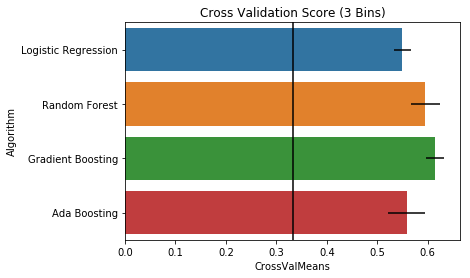

In [9]:
#Evaluate with 3 bins
Y_bins3, bins3_labels, cv_res3, g3 = classifier_eval(classifiers,bins=3)
g3.set_title("Cross Validation Score (3 Bins)")
plt.axvline(np.divide(1,3), color="black")
plt.show()

In [10]:
print("Markup Percentage Bins:\n {} - {}, \n {} - {}, \n {} - {}".format(bins3_labels[0],bins3_labels[1],
                                                                 bins3_labels[1],bins3_labels[2],
                                                                 bins3_labels[2],bins3_labels[3]))

Markup Percentage Bins:
 -72.53731343283583 - 84.32735042735041, 
 84.32735042735041 - 125.0, 
 125.0 - 6578.999999999999


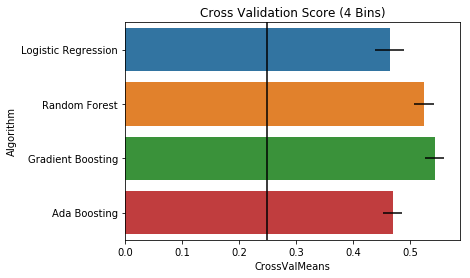

In [11]:
#Evaluate with 4 bins
Y_bins4, bins4_labels, cv_res4, g4 = classifier_eval(classifiers,bins=4)
g4.set_title("Cross Validation Score (4 Bins)")
plt.axvline(np.divide(1,4), color="black")
plt.show()

In [12]:
print("Markup Percentage Bins:\n [{} - {}), \n [{} - {}), \n [{} - {}), \n [{} - {}]".format(bins4_labels[0],bins4_labels[1],
                                                                 bins4_labels[1],bins4_labels[2],
                                                                 bins4_labels[2],bins4_labels[3],
                                                                 bins4_labels[3],bins4_labels[4]))

Markup Percentage Bins:
 [-72.53731343283583 - 75.65390969162995), 
 [75.65390969162995 - 101.55714285714285), 
 [101.55714285714285 - 146.66666666666666), 
 [146.66666666666666 - 6578.999999999999]


## 3.3 Learning Curves

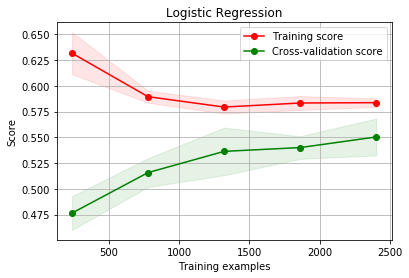

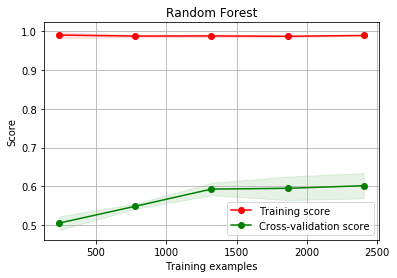

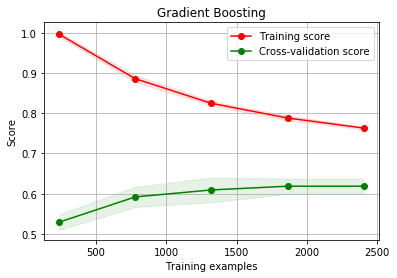

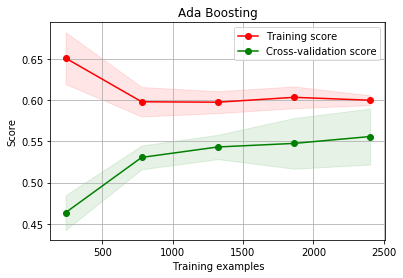

In [13]:
g = plot_learning_curve(lgr, 'Logistic Regression', X, Y_bins3, ylim=None, cv=cv,
                       n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(rfc, 'Random Forest', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(gbc, 'Gradient Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
g = plot_learning_curve(abc, 'Ada Boosting', X, Y_bins3, ylim=None, cv=cv,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))

## 3.4 Tree Classifiers Feature Importance (With Three Bins)

In [14]:
#Fit each classifier
for classifier in classifiers[1:]:
    classifier.fit(X,Y_bins3)

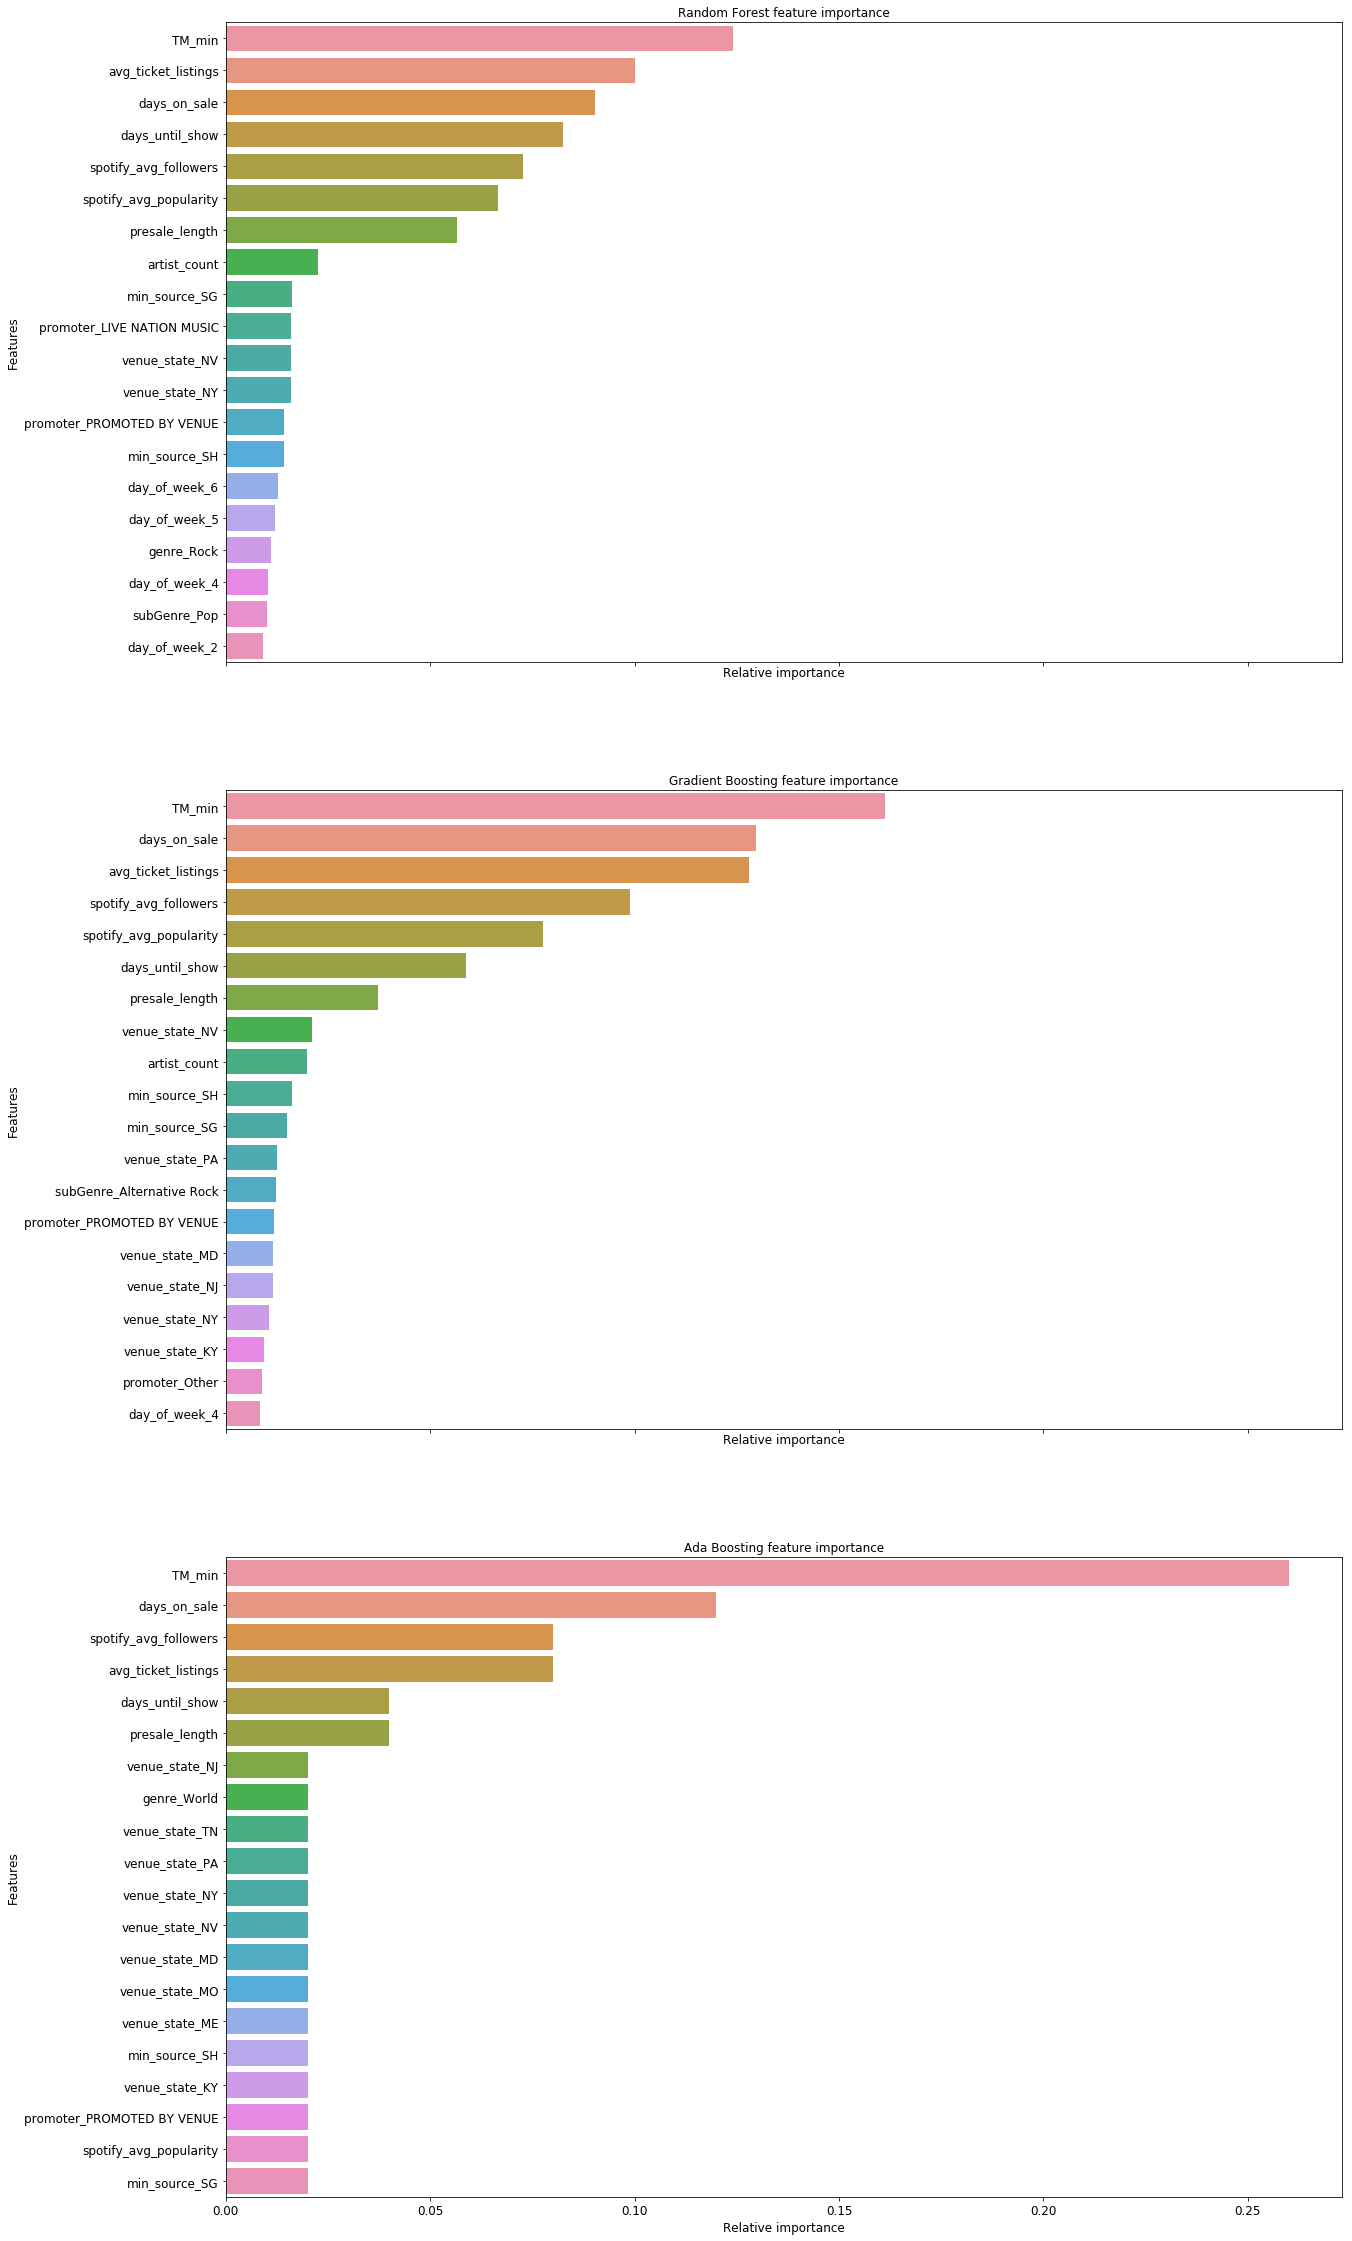

In [15]:
nrows = 3
ncols = 1
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(20,40),squeeze=False)

names_classifiers = [("Random Forest", rfc),("Gradient Boosting",gbc),("Ada Boosting",abc)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:20]
        g = sns.barplot(y=X.columns[indices][:20],x = classifier.feature_importances_[indices][:20] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=12)
        g.set_title(name + " feature importance")
        nclassifier += 1

### Analysis:
Feature importance varies by classifier. However, the top six features of each classifier (In varying orders) are TM min, Days on Sale, Spotify Average Followers, Average Ticket Listings, Days until Show, and Presale Length